# Avaliação de doença em folhas
https://www.kaggle.com/code/jagannathmanchiraju/leaf-disease-detection

- Bactéria
- Fungo
- Nemátodos
- Vírus
- Normal

### Excluindo Imagens Corrompidas

In [1]:
import cv2
import os

def exclude_files(path_to_exclude):
    paths_to_exclude= os.listdir(path_to_exclude)
    for path in paths_to_exclude:
        for file in os.listdir(os.path.join(path_to_exclude,path)):      
            img = cv2.imread(os.path.join(path_to_exclude,path,file))
            if img is None:
                print("\t Exclude file: {}".format(file))
                os.system("del {}".format((os.path.join(path_to_exclude,path,file))))

exclude_files('Datasets')

	 Exclude file: stage1_backup.pth


# Carregando as Imagens

['Bacteria', 'Fungi', 'Nematodes', 'Normal', 'Virus']

20% do dataset será usado para validação
Serão usadas 192 imagens de treinamento e 47 imagens para validação


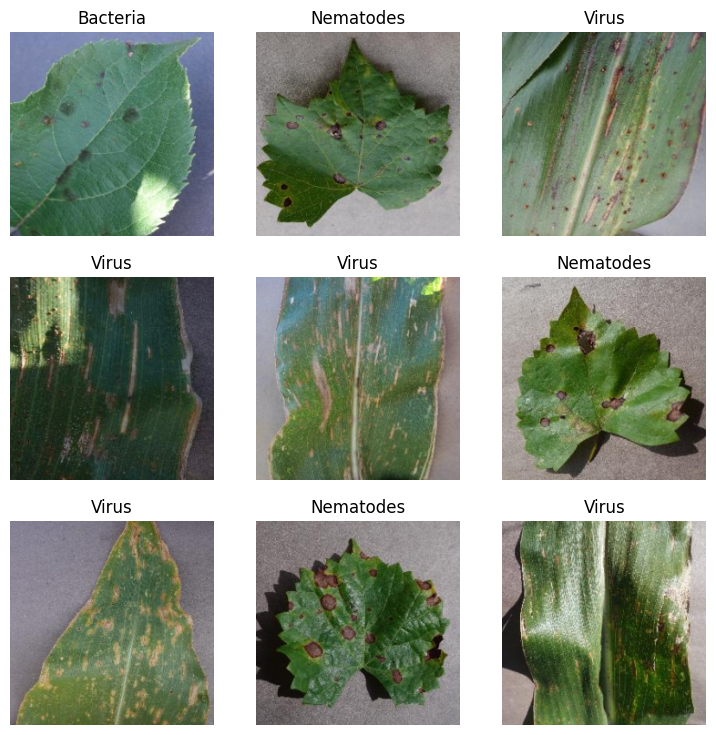

In [2]:
from fastai.vision.all import *
import numpy as np

np.random.seed(53)
dls = ImageDataLoaders.from_folder('Datasets', train='.', valid_pct=0.2, seed=42, item_tfms=Resize(224))
print(dls.vocab)
print(f"\n20% do dataset será usado para validação")
print( f"Serão usadas {len(dls.train_ds)} imagens de treinamento e {len(dls.valid_ds)} imagens para validação")
dls.show_batch()

### Instanciando o modelo

In [3]:
learn = vision_learner(dls, models.resnet34, metrics=error_rate)

c:\Users\hugog\GitHub\SENAI_minicurso\env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\hugog\GitHub\SENAI_minicurso\env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Treinando o model

In [4]:
learn.fit_one_cycle(10)
learn.save('stage1')

epoch,train_loss,valid_loss,error_rate,time
0,3.006575,2.726287,0.808511,00:14
1,2.601375,1.463407,0.425532,00:13
2,1.970948,0.895424,0.234043,00:14
3,1.506389,0.637609,0.234043,00:14
4,1.197244,0.431466,0.191489,00:14
5,0.974406,0.291504,0.127660,00:15
6,0.812565,0.218261,0.042553,00:14
7,0.692133,0.182174,0.042553,00:14
8,0.599417,0.160951,0.042553,00:14
9,0.527162,0.150290,0.042553,00:14


Path('Datasets/models/stage1.pth')

### Carregando o modelo treinado

In [5]:
#learn.load('stage1')

## Interpretando os resultados

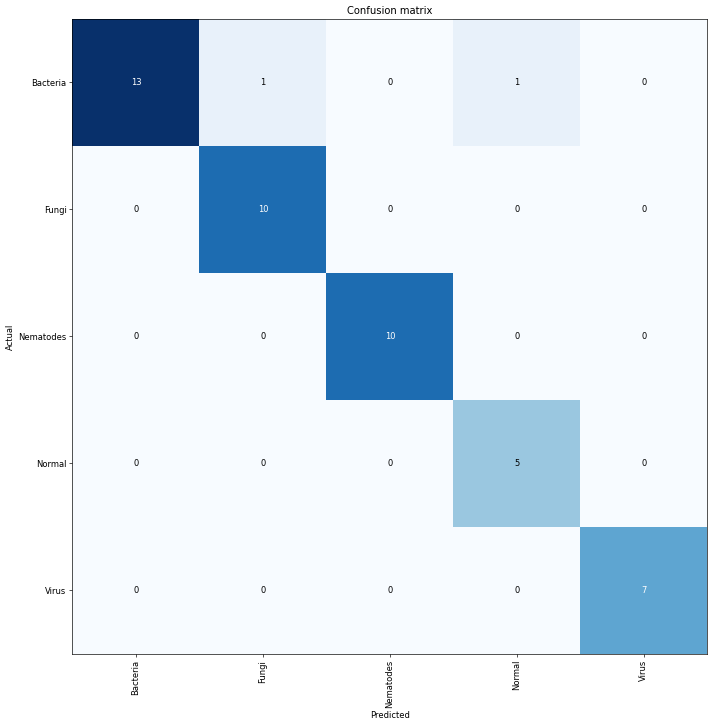

In [6]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

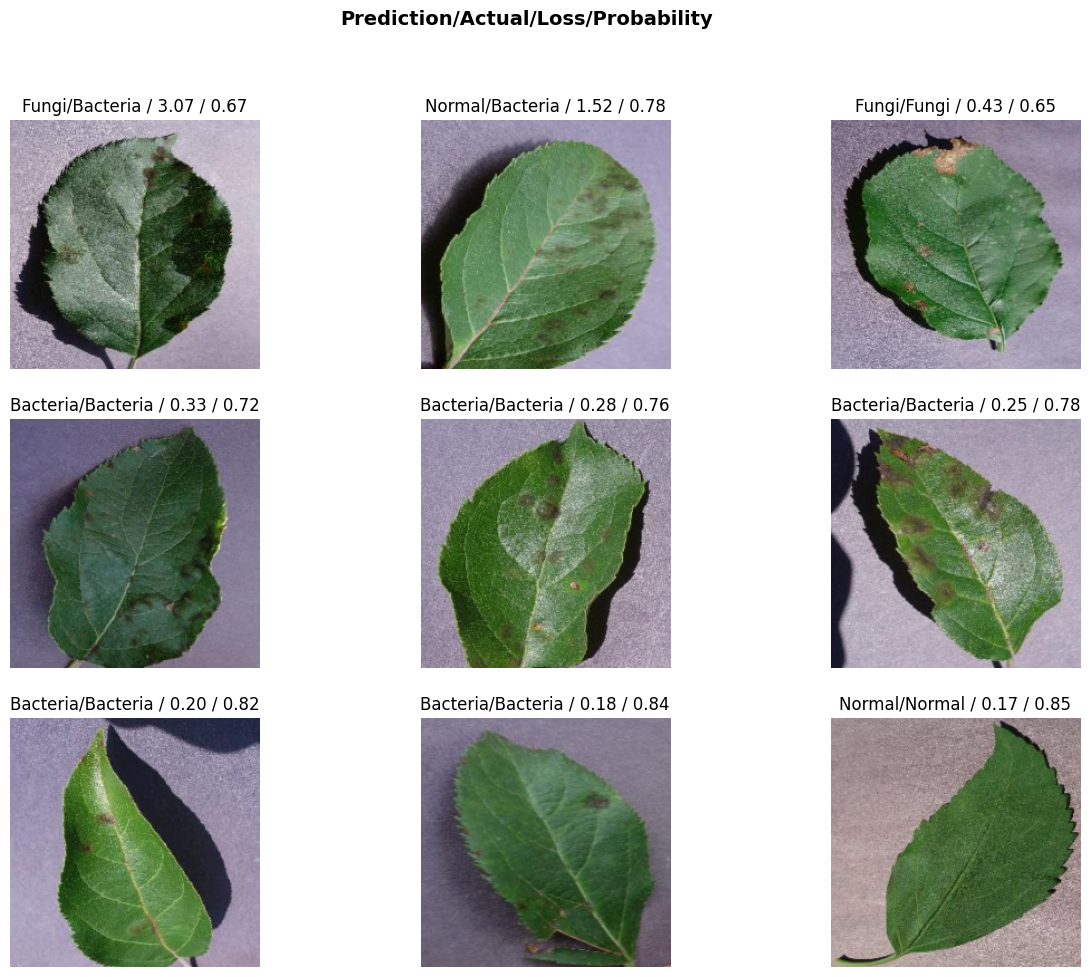

In [7]:
interp.plot_top_losses(9, figsize=(15,11)) #,heatmat=True

# Realizando predições com o modelo treinado

In [8]:
#from torchvision import transforms
from PIL import Image
import random


CLASSE DE TESTE: Fungi
IMAGE DE TESTE : 1fe7faa9-61a7-4152-9a85-a57d9486af0a___JR_FrgE.S 8599.JPG


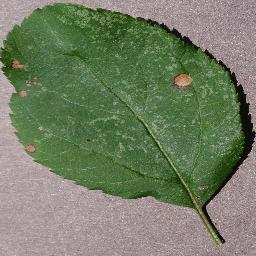

In [9]:
## Open Image
test_class = random.choice(dls.vocab)
print(f"CLASSE DE TESTE: {test_class}")
test_image = random.choice(os.listdir(os.path.join('Datasets',test_class)))
print(f"IMAGE DE TESTE : {test_image}")

image_path = os.path.join('Datasets',test_class,test_image)
image = Image.open(image_path).convert('RGB')
image


Probabilities: 
	Bacteria: 0.00 %
	Fungi: 99.88 %
	Nematodes: 0.08 %
	Normal: 0.04 %
	Virus: 0.00 %

Prediction: FUNGI


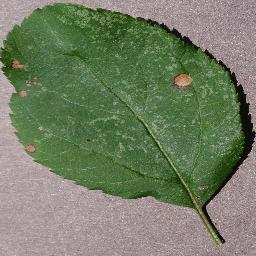

In [10]:
# predict image with learn
pred,pred_idx,probs = learn.predict(image)
print("Probabilities: ")
for i in range(len(dls.vocab)):
    print(f"\t{dls.vocab[i]}: {probs[i].item()*100:.02f} %")

print(f"\nPrediction: {pred.upper()}")
image


# GRAD-CAM

In [11]:
class Hook():
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_func)   
    def hook_func(self, m, i, o): self.stored = o.detach().clone()
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.hook.remove()
class HookBwd():
    def __init__(self, m):
        self.hook = m.register_backward_hook(self.hook_func)   
    def hook_func(self, m, gi, go): self.stored = go[0].detach().clone()
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.hook.remove()

In [12]:
x = first(dls.test_dl([image]))[0]
cls = list(dls.vocab).index(test_class)
with HookBwd(learn.model[0]) as hookg:
    with Hook(learn.model[0]) as hook:
        output = learn.model.eval()(x)
        act = hook.stored
    output[0,cls].backward()
    grad = hookg.stored
     

c:\Users\hugog\GitHub\SENAI_minicurso\env\lib\site-packages\torch\nn\modules\module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


In [13]:
w = grad[0].mean(dim=[1,2], keepdim=True)
cam_map = (w * act[0]).sum(0)
cam_map.shape

torch.Size([7, 7])

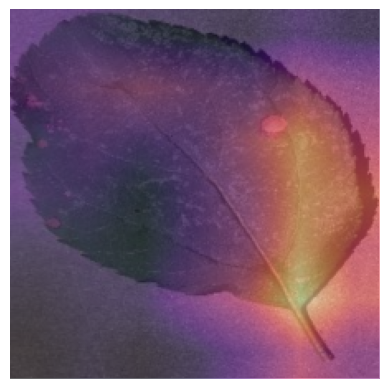

In [14]:
x_dec = TensorImage(dls.train.decode((x,))[0][0])
_,ax = plt.subplots()
x_dec.show(ctx=ax)
ax.imshow(cam_map.detach().cpu(), alpha=0.6, extent=(0,224,224,0),
              interpolation='bilinear', cmap='magma');